The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


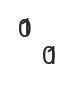

In [135]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import dataframe_image as dfi
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS, get_aa_properties
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.utils import pkl_load, pkl_dump, get_palette
from src.bootstrap import bootstrap_eval, get_pval, plot_pval
from src.models import FFNetPipeline
from src.bootstrap import get_pval, plot_pval
import torch
from torch import nn
from torch import functional as F
PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
tmppal = sns.color_palette('hsv', n_colors=15)
NEWPAL = HSV + [tmppal[-3], tmppal[7]]
mpl.rcParams['figure.dpi'] = 180

In [2]:
cedar_aligned = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')

# self explo

In [3]:
from src.models import *

In [80]:
def sliding_window(x, window_size):
    # Compute the number of windows per sequence
    num_windows = x.size(1) - window_size + 1

    # Create a tensor of shape (N, num_windows, window_size, D) containing the sliding windows
    windows = torch.nn.functional.unfold(x.transpose(1, 2), (window_size, 1)).transpose(1, 2).view(x.size(0), num_windows, window_size, x.size(2))

    # Mask out the padded positions
    mask = (x != 0).unsqueeze(-1).expand_as(windows)
    windows = torch.masked_select(windows, mask).view(x.size(0), num_windows, -1)

    return windows

In [242]:
from src.data_processing import encode_batch
sample = cedar_aligned.sample(100, random_state=100)
sample.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,HLA,agg_label,fold,Peptide,wild_type,icore_mut,core_mut,...,icore_improves_binder_0_75,mixed_input_binder_0_75,mixed_rank_binder_0_75,icore_improves_1,mixed_input_1,mixed_rank_1,icore_improves_binder_1,mixed_input_binder_1,mixed_rank_binder_1,expanded_input
996,996,996,996,HLA-A0201,0,1,IMQPSVVIPA,IVQPSVVIPA,MQPSVVIPA,MQPSVVIPA,...,False,IMQPSVVIPA,2.8394,False,IMQPSVVIPA,2.8394,False,IMQPSVVIPA,2.8394,MQPSVVIPA
249,249,249,249,HLA-A2402,0,5,AYLEAIHTF,AYLEAIHNF,AYLEAIHTF,AYLEAIHTF,...,False,AYLEAIHTF,0.0006,False,AYLEAIHTF,0.0006,False,AYLEAIHTF,0.0006,AYLEAIHTF
774,774,774,774,HLA-B3901,0,7,GRMRSLEAL,GRMRCLEAL,GRMRSLEAL,GRMRSLEAL,...,False,GRMRSLEAL,0.2547,False,GRMRSLEAL,0.2547,False,GRMRSLEAL,0.2547,GRMRSLEAL
1617,1617,1617,1617,HLA-C0702,1,8,LYIWFKTACL,LYLWFKTACL,YIWFKTACL,YIWFKTACL,...,False,LYIWFKTACL,4.9286,False,LYIWFKTACL,4.9286,False,LYIWFKTACL,4.9286,YIWFKTACL
3004,3004,3004,3004,HLA-B0801,0,1,YTTVRALTL,YTTVRALTR,YTTVRALTL,YTTVRALTL,...,False,YTTVRALTL,0.1560,False,YTTVRALTL,0.1560,False,YTTVRALTL,0.1560,YTTVRALTL


In [246]:
x = encode_batch(sample['Peptide'].values, 12, 'onehot')
x.shape

torch.Size([100, 12, 20])

In [224]:
# Say K = 5
max_len = 12
N = 3
K = 5
x_base = torch.rand([N, max_len, 20])
x = x.view(N,-1)
y = torch.randint(1, size=(N, 1)).float()
y[N-1]=1
y_exp = y.expand((N, max_len-K+1)).view(-1, max_len-K+1, 1)


criterion = nn.BCEWithLogitsLoss(reduction='none')
# Here need to fix expander to return the x_expand_flat 
xp = InputExpander(window_size=K, max_len=max_len, indel=False)
z=xp(x_base)

n_hidden = 10
model = nn.Sequential(nn.Linear(K*20, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 1))

# expanding input stuff
x_sliding = x_base.unfold(1, K, 1)
# Reshape the tensor to the desired output shape
x_expand = x_sliding.transpose(2, 3).reshape(len(x_base), max_len-K+1, K, 20)
x_expand_flat = x_expand.flatten(2,3)

y_pred = model(x_expand_flat)
# x_expand should be correct and z is transposed i.e. wrong
x_expand.shape, z.shape, x_base.shape, (x_base[0][3:3+K,:] == x_expand[0,3,:]).all(), x_expand_flat.shape



(torch.Size([3, 8, 5, 20]),
 torch.Size([3, 5, 8, 20]),
 torch.Size([3, 12, 20]),
 tensor(True),
 torch.Size([3, 8, 100]))

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy_with_logits as bce_with_logits

class SlidingWindowDataset(Dataset):
    def __init__(self, x, y, window_size):
        self.x = x
        self.y = y
        self.window_size = window_size

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x_window = self.x[idx][:, None, :]
        x_window = nn.functional.unfold(x_window, (1, self.window_size))[0]
        y = self.y[idx]
        return x_window, y

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(20, 10)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x

def train(model, optimizer, criterion, dataloader):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(x_batch)
    return total_loss / len(dataloader.dataset)

def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item() * len(x_batch)
    return total_loss / len(dataloader.dataset)

# Define the input tensor x and target tensor y
x = torch.randn(3000, 10, 20)
y = torch.randint(0, 2, (3000, 1)).float()

# Define the window size and batch size
window_size = 5
batch_size = 128

# Define the dataset and dataloader
dataset = SlidingWindowDataset(x, y, window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the model, loss function, and optimizer
model = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())

# Train the model
for epoch in range(10):
    train_loss = train(model, optimizer, criterion, dataloader)
    valid_loss = evaluate(model, criterion, dataloader)
    print(f"Epoch {epoch + 1:03d}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# Compute the best scores
model.eval()
best_scores = []
with torch.no_grad():
    for x_batch, y_batch in dataloader:
        scores = model(x_batch).squeeze()
        losses = bce_with_logits(scores, y_batch)
        best_indices = losses.argmin(dim=1)
        best_scores_batch = scores.gather(1, best_indices.view(-1, 1)).view(-1, 1)
        best_scores.append


# tests

In [ ]:
class XX(nn.Module):
    """
    This just runs the forward loop and selects the best loss.
    The inputs should be split in the ExpandDataset class with the unfold/transpose/reshape/flatten etc.
    """
    def __init__(self, n_hidden, window_size,
                 activation = nn.ReLU(),
                 dropout=0.0, indel=False):
        super(NNAlign, self).__init__()
        self.matrix_dim = 21 if indel else 20
        self.window_size = window_size
        self.in_layer = nn.Linear(self.window_size * self.matrix_dim, n_hidden)
        self.out_layer = nn.Linear(n_hidden, 1)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.act = activation

    def forward(self, x):
        x = self.dropout(self.in_layer(x))
        # Switch submer-feature dim to batchnorm then switch again to get preds
        x = self.act(x)
        x = self.out_layer(x)
        with torch.no_grad():
            
        return x


In [117]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import copy
import multiprocessing
import os

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from src.utils import set_mode, set_device
from src.data_processing import get_dataset, assert_encoding_kwargs, to_tensors
from src.metrics import get_metrics, get_predictions, get_mean_roc_curve
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from functools import partial
from tqdm.auto import tqdm


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=1e-6, name='checkpoint'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.prev_best_score = np.Inf
        self.delta = delta
        self.path = f'{name}.pt'

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0
        else:
            # This condition works for AUC ; checks that the AUC is below the best AUC +/- some delta
            if score < self.best_score + self.delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(score, model)
                self.counter = 0

    def save_checkpoint(self, score, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Prev best score: ({self.prev_best_score:.6f} --> {score:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.prev_best_score = score


def invoke(early_stopping, loss, model, implement=False):
    if implement:
        early_stopping(loss, model)
        if early_stopping.early_stop:
            return True
    else:
        return False


def train_model_step(model, criterion, optimizer, train_loader):
    """
    TODO: Include a scheduler for the optimizer
    Args:
        model:
        criterion:
        optimizer:
        train_loader:

    Returns:

    """
    model.train()
    train_loss = 0
    y_scores, y_true = [], []
    for x_train, y_train in train_loader:
        output = model(x_train)
        loss = criterion(output, y_train)
        # if torch.isnan(torch.tensor(loss)): print('NaN losses!'); return torch.nan
        # NNAlign code to select the best sub-mer for each datapoint and only backprop from those

        best_idx = loss.argmin(dim=1).unsqueeze(1)
        selected_loss = torch.gather(loss, 1, best_idx)
        optimizer.zero_grad()
        selected_loss.mean().backward()
        optimizer.step()

        # Here select the best scoring kmers as output, then computes metrics
        with torch.no_grad():
            selected_output = torch.gather(output, 1, best_idx)
            y_probs = F.sigmoid(selected_output)
            # Output should be sigmoid scores (range [0,1])
            y_scores.append(y_probs.flatten())
            # Since all labels are the same for sub-kmers, just take an index and flatten it
            y_true.append(y_train[:,0].flatten())

        train_loss += selected_loss.mean().item() * y_train.shape[0]

    # Concatenate the y_pred & y_true tensors and compute metrics
    y_scores, y_true = torch.cat(y_scores), torch.cat(y_true)
    train_metrics = get_metrics(y_true, y_scores, threshold=0.5, reduced=True)
    # Normalizes to loss per batch
    train_loss /= len(train_loader.dataset)
    return train_loss, train_metrics


def eval_model_step(model, criterion, valid_loader):
    model.eval()
    # disables gradient logging
    valid_loss = 0
    y_scores, y_true = [], []
    with torch.no_grad():
        for x_valid, y_valid in valid_loader:
            output = model(x_valid)
            loss = criterion(output, y_valid)
            best_idx = loss.argmin(dim=1).unsqueeze(1)
            selected_loss = torch.gather(loss, 1, best_idx)
            selected_output = torch.gather(output, 1, best_idx)
            valid_loss += (selected_loss.mean().item() * y_valid.shape[0])
            # Output should be sigmoid scores (range [0,1])
            # Output should be sigmoid scores (range [0,1])
            y_scores.append(F.sigmoid(output)[:,0].flatten())
            # Since all labels are the same for sub-kmers, just take an index and flatten it
            y_true.append(y_valid[:, 0].flatten())

    # Concatenate the y_pred & y_true tensors and compute metrics
    y_scores, y_true = torch.cat(y_scores), torch.cat(y_true)
    valid_metrics = get_metrics(y_true, y_scores, threshold=0.5, reduced=True)
    # Normalizes to loss per batch
    valid_loss /= len(valid_loader.dataset)
    return valid_loss, valid_metrics


def train_loop(model, train_loader, valid_loader, device, criterion, optimizer, n_epochs, early_stopping=False,
               patience=20, delta=1e-7, filename='checkpoint', verbosity: int = 0):
    # Very bad implementation in case loader is actually a dataset
    if type(train_loader) == torch.utils.data.dataset.TensorDataset:
        train_loader = DataLoader(train_loader)
    model.to(device)
    train_losses, valid_losses, train_metrics, valid_metrics = [], [], [], []
    early_stop = EarlyStopping(delta=delta, patience=patience, name=filename)
    valid_auc = []  # Used to check early stopping.
    range_ = tqdm(range(1, n_epochs + 1), leave=False) if verbosity > 0 else range(1, n_epochs + 1)
    e = 0
    best_auc = 0
    best_epoch = 0
    best_loss = 100
    for epoch in range_:
        train_loss, train_metrics_ = train_model_step(model, criterion, optimizer, train_loader)
        valid_loss, valid_metrics_ = eval_model_step(model, criterion, valid_loader)
        if torch.isnan(torch.tensor(train_loss)) or torch.isnan(torch.tensor(valid_loss)):
            print(f'NaN losses at {epoch} epoch.');
            break
        # updating list of scores etc.
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_metrics.append(train_metrics_)
        valid_metrics.append(valid_metrics_)
        valid_auc.append(valid_metrics_['auc'])
        # print losses/metrics if verbose = 2
        if (epoch % (n_epochs // 10) == 0 or epoch == 1) and verbosity == 2:
            tqdm.write(f'Train Epoch: {epoch}\tTrain Loss: {train_loss:.5f}\tEval Loss:{valid_loss:.5f}\n' \
                       f'\tTrain AUC, Accuracy:\t{train_metrics_["auc"], train_metrics_["accuracy"]}\n' \
                       f'\tEval AUC, Accuracy:\t{valid_metrics_["auc"], valid_metrics_["accuracy"]}')
        # If verbose=1, only show start, middle, end.
        elif (epoch % (n_epochs // 2) == 0 or epoch == 1 or epoch == n_epochs + 1) and (verbosity == 1):
            print(f'\nTrain Epoch: {epoch}\tTrain Loss: {train_loss:.5f}\tEval Loss:{valid_loss:.5f}\n' \
                  f'\tTrain AUC, Accuracy:\t{train_metrics_["auc"], train_metrics_["accuracy"]}\n' \
                  f'\tEval AUC, Accuracy:\t{valid_metrics_["auc"], valid_metrics_["accuracy"]}')
        # TODO : For now, early stopping is disabled and just train to the end and re-load the best model
        if valid_metrics_['auc'] > best_auc:
            best_epoch = epoch
            best_loss = valid_loss
            best_auc = valid_metrics_['auc']
            torch.save(model.state_dict(), f'{filename}.pt')

        # TODO : Re-implement early stopping
        # # Stop training if early stopping, using AUC as metric
        # if early_stopping:
        #     if invoke(early_stop, valid_auc[-1], model, implement=early_stopping):
        #         model.load_state_dict(torch.load(f'{filename}.pt'))
        #         tqdm.write(f'\nEarly Stopping at epoch={epoch};'
        #                    f'current best valid loss:{valid_loss}; '
        #                    f'previous avg losses: {np.mean(valid_losses[-patience:-1]),}, previous losses std: {np.std(valid_losses[-patience:-1])}\n'
        #                    f'\tTrain AUC, Accuracy:\t{train_metrics_["auc"], train_metrics_["accuracy"]}\n' \
        #                    f'\tEval AUC, Accuracy:\t{valid_metrics_["auc"], valid_metrics_["accuracy"]}')
        #         e = epoch
        #         break
    print(f'Reloading best model at {best_epoch} epochs, with best AUC: {best_auc}, ""best"" valid loss = {best_loss}')
    model.load_state_dict(torch.load(f'{filename}.pt'))
    # flatten metrics into lists for easier printing, i.e. make dict of list from list of dicts
    results_metrics = {'train': {k: [dic[k] for dic in train_metrics] for k in train_metrics[0]},
                       'valid': {k: [dic[k] for dic in valid_metrics] for k in valid_metrics[0]}}
    results_metrics['train']['losses'] = train_losses
    results_metrics['valid']['losses'] = valid_losses
    results_metrics['break_epoch'] = e

    # Return the model in eval mode to be sure
    model.eval()
    return model, results_metrics


def reset_model_optimizer(model, optimizer, seed):
    """
    TODO: Include a scheduler for the optimizer
    Args:
        model:
        optimizer:
        seed:

    Returns:

    """
    # Deepcopy of model and reset the params so it's untied from the previous model
    model = copy.deepcopy(model)
    model.reset_parameters(seed=seed)
    model.train()
    # Re-initialize the optimizer object with the same kwargs without keeping the parameters
    # This only handles a single param groups so far
    optimizer_kwargs = {k: v for k, v in optimizer.param_groups[0].items() if k != 'params'}
    optimizer = optimizer.__class__(model.parameters(), **optimizer_kwargs)
    return model, optimizer


##################################
############ NN stuff ############
##################################

def parallel_nn_train_wrapper(train_dataframe, x_test, ics_dict, device,
                              encoding_kwargs, standardize, fold_out, fold_in,
                              model, optimizer, criterion, training_kwargs: dict):
    """
    Wrapper to parallelize training for all inner folds,
    returns the trained model, train_metrics and evaluated on x_test (which is just x for df.query('fold==@fold_out')
    Args:
        train_dataframe:
        x_test:
        ics_dict:
        device:
        encoding_kwargs:
        standardize:
        fold_out:
        fold_in:
        model:
        optimizer:
        criterion:
        training_kwargs:

    Returns:

    """
    seed = int(f'{fold_out}{fold_in}')
    model, optimizer = reset_model_optimizer(model, optimizer, seed)
    train = train_dataframe.query('fold != @fold_out and fold != @ fold_in').reset_index(drop=True)
    valid = train_dataframe.query('fold == @fold_in').reset_index(drop=True)
    # Converting to tensors
    x_train, y_train = get_dataset(train, ics_dict, **encoding_kwargs)
    x_train, y_train = to_tensors(x_train, y_train, device)
    x_valid, y_valid = get_dataset(valid, ics_dict, **encoding_kwargs)
    x_valid, y_valid = to_tensors(x_valid, y_valid, device)
    # Fitting a standardizer ; model must be in training mode to fit so just in case
    model.train()
    if standardize and hasattr(model, 'standardizer'):
        model.fit_standardizer(x_train)
    # Don't get dataloader for X_
    train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=32)
    valid_loader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=32)
    # Making a deep copy to update the checkpoint filename to include outer-inner fold
    training_kwargs = copy.deepcopy(training_kwargs)
    training_kwargs['filename'] = f'{training_kwargs["filename"]}_o{fold_out}_i{fold_in}'

    model, train_metrics = train_loop(model, train_loader, valid_loader, device, criterion, optimizer,
                                      **training_kwargs)

    # TODO : Deprecate this
    # if train_metrics['break_epoch'] < 75:
    #     print(f'\n\n{"#"*10}\n\n')
    #     print(f'THIS FUCKED UP:\t{train_metrics["break_epoch"]}\tF_in={fold_in},\tF_out={fold_out},\tseed={seed}')
    #     print(train_metrics['valid']['losses'])
    #     print(train_metrics['valid']['auc'])

    with torch.no_grad():
        y_pred_test = model(x_test.to(device))

    return model, train_metrics, y_pred_test


def nested_kcv_train_nn(dataframe, model, optimizer, criterion, device, ics_dict, encoding_kwargs, training_kwargs,
                        n_jobs=None):
    """
    TODO: Have the fct (here or after return in another fct/scope) save the models checkpoints from the models dict

    Here should set optimizer kwargs and model params before calling this fct
    Training_kwargs should only be for stuff like early stopping, n_epochs, etc.
    ex:
        model = NetworkClass(n_input=20, n_hidden=50)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = torch.nn.CrossEntropyLoss()
        models, train_metrics, test_metrics = nested_kcv_train_nn(data, model, optimizer, criterion, device, ics_dict,
                                                                  encoding_kwargs, training_kwargs, n_jobs)
    Args:
        dataframe:
        model:
        optimizer:
        criterion:
        device:
        ics_dict:
        encoding_kwargs:
        training_kwargs:
        n_jobs:

    Returns:
        models_dict
        train_metrics
        test_metrics
    """
    encoding_kwargs['standardize'] = True
    encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
    models_dict = {}
    test_metrics = {}
    train_metrics = {}
    folds = sorted(dataframe.fold.unique())
    std = encoding_kwargs.pop('standardize')
    # For now, when using GPU, use a single core
    if 'cuda' in device.lower():
        n_jobs = 1
    else:
        n_jobs = min(multiprocessing.cpu_count() - 1, len(folds) - 1) if n_jobs is None \
            else n_jobs if (n_jobs is not None and n_jobs <= multiprocessing.cpu_count()) \
            else multiprocessing.cpu_count() - 1

    for fold_out in tqdm(folds, leave=False, desc='Outer fold', position=2):
        test = dataframe.query('fold==@fold_out').reset_index(drop=True)
        x_test, y_test = get_dataset(test, ics_dict, **encoding_kwargs)
        x_test, y_test = to_tensors(x_test, y_test, device)
        inner_folds = sorted([f for f in folds if f != fold_out])
        train_wrapper_ = partial(parallel_nn_train_wrapper, train_dataframe=dataframe, x_test=x_test,
                                 ics_dict=ics_dict, device=device, encoding_kwargs=encoding_kwargs, standardize=std,
                                 fold_out=fold_out, model=model, optimizer=optimizer, criterion=criterion,
                                 training_kwargs=training_kwargs)
        output = Parallel(n_jobs=n_jobs)(
            delayed(train_wrapper_)(fold_in=fold_in) for fold_in in tqdm(inner_folds, desc='Inner Folds',
                                                                         leave=False, position=1))
        models_dict[fold_out] = [x[0] for x in output]
        train_metrics[fold_out] = {k: v for k, v in
                                   zip(inner_folds, [x[1] for x in output])}
        avg_prediction = [x[2] for x in output]
        avg_prediction = torch.mean(torch.stack(avg_prediction), dim=0).detach().cpu().numpy()
        test_metrics[fold_out] = get_metrics(y_test, avg_prediction)
    return models_dict, train_metrics, test_metrics


def parallel_nn_eval_wrapper(test_dataframe, models_list, ics_dict, device,
                             train_dataframe, encoding_kwargs, fold_out):
    """
    This fct is for a given outer fold, and needs a list of models trained for this outer fold
    i.e. models_list = models_dict[fold_out]
    Args:
        test_dataframe:
        models_list:
        ics_dict:
        train_dataframe:
        encoding_kwargs:
        fold_out:

    Returns:

    """
    if 'fold' in test_dataframe.columns and test_dataframe.equals(train_dataframe):
        test_df = test_dataframe.query('fold==@fold_out')
    else:
        test_df = test_dataframe.copy().reset_index(drop=True)

    if train_dataframe is not None and not train_dataframe.equals(test_dataframe):
        tmp = train_dataframe.query('fold != @fold_out')
        train_peps = tmp[encoding_kwargs['seq_col']].unique()
        test_df = test_df.query(f'{encoding_kwargs["seq_col"]} not in @train_peps')

    set_device(models_list, device)
    predictions_df = get_predictions(test_df, models_list, ics_dict, encoding_kwargs)
    test_metrics = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                               predictions_df['pred'].values)
    if device != 'cpu':
        # If device was initially cuda, resets it to CPU after eval for space
        set_device(models_list, 'cpu')
    return predictions_df, test_metrics


def evaluate_trained_models_nn(test_dataframe, models_dict, ics_dict, device,
                               train_dataframe=None, encoding_kwargs=None,
                               concatenated=False, only_concat=False, n_jobs=None):
    """
    No need to training kwargs here as models should be in eval mode
    Args:
        test_dataframe:
        models_dict:
        ics_dict:
        train_dataframe:
        encoding_kwargs:
        concatenated:
        only_concat:
        n_jobs:

    Returns:

    """
    if 'standardize' in encoding_kwargs.keys():
        del encoding_kwargs['standardize']
    set_mode(models_dict, 'eval')
    eval_wrapper_ = partial(parallel_nn_eval_wrapper, test_dataframe=test_dataframe, ics_dict=ics_dict,
                            device=device, train_dataframe=train_dataframe, encoding_kwargs=encoding_kwargs)
    n_jobs = 1 if device != 'cpu' else len(models_dict.keys()) if (
            n_jobs is None and len(models_dict.keys()) <= multiprocessing.cpu_count()) else n_jobs
    output = Parallel(n_jobs=n_jobs)(delayed(eval_wrapper_)(fold_out=fold_out, models_list=models_list) \
                                     for (fold_out, models_list) in tqdm(models_dict.items(),
                                                                         desc='Eval Folds',
                                                                         leave=False,
                                                                         position=2))
    predictions_df = [x[0] for x in output]
    test_metrics = [x[1] for x in output]
    test_results = {k: v for k, v in zip(models_dict.keys(), test_metrics)}
    predictions_df = pd.concat(predictions_df)

    # Here get the concat results
    if concatenated:
        test_results['concatenated'] = get_metrics(predictions_df[encoding_kwargs['target_col']].values,
                                                   predictions_df['pred'].values)
    # Either concatenated, or mean predictions
    else:
        # obj_cols = [x for x,y in zip(predictions_df.dtypes.index, predictions_df.dtypes.values) if y=='object']
        cols = [encoding_kwargs['seq_col'], encoding_kwargs['hla_col'], encoding_kwargs['target_col']]
        mean_preds = predictions_df.groupby(cols).agg(mean_pred=('pred', 'mean'))
        predictions_df = test_dataframe.merge(mean_preds, left_on=cols, right_on=cols, suffixes=[None, None])
    # print('there', len(predictions_df))

    if only_concat and concatenated:
        keys_del = [k for k in test_results if k != 'concatenated']
        for k in keys_del:
            del test_results[k]

    return test_results, predictions_df

#
# def kcv_tune_nn_freq(dataframe, model_constructor, ics_dict, encoding_kwargs, hyperparams,
#                      criterion, optimizer, device, outdir):
#     """
#     In the end, should return a dataframe that houses all the results
#     Args:
#         model_constructor:
#         dataframe:
#         base_model:
#         ics_dict:
#         encoding_kwargs:
#         hyperparams:
#
#     Returns:
#
#     """
#     encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
#
#     folds = sorted(dataframe.fold.unique())
#     # Here in "tune" mode, keep 20% of the dataset as test set
#     # Do a standard (not nested) crossvalidation on the remaining 8 folds
#     # This is quicker and used to tune hyperparameters when running MANY MANY conditions
#     seed = 0
#     # Randomly pick 20% & split
#     n_choice = int(0.2 * len(folds))
#     test_folds = sorted(np.random.choice(folds, n_choice))
#     train_folds = sorted([x for x in folds if x not in test_folds])
#     # Get test arrays
#     test = dataframe.query('fold in @test_folds')
#     x_test_base, y_test = get_freq_tensors(test, ics_dict, device, **encoding_kwargs)
#     # Get train df
#     dataset = dataframe.query('fold in @train_folds')
#     # Set up the grid and a list to house the dicts, which will be converted into dict of lists and then dataframe
#     params_grid = list(ParameterGrid(hyperparams))
#     list_dict_results = []
#     list_roc_curves = []
#     n_in = x_test_base.shape[1]
#     for hyperparameter_selection in tqdm(params_grid, desc='Hyperparameters', leave=False):
#         models_dict = {}
#         test_metrics = {}
#         train_metrics = {}
#         avg_prediction = []
#         # This is ONE crossvalidation loop, will do all of the 80% remaining folds available
#         # Here, the model is set with the hyperparameters from the grid
#         model = model_constructor(n_in, **hyperparameter_selection).to(device)
#
#         for fold in train_folds:
#             model, optimizer = reset_model_optimizer(model, optimizer, seed)
#             # Create the sub-dict and put the model into the models dict
#             train_metrics[fold] = {}
#             # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
#             # Query subset dataframe and get encoded data and targets
#             train = dataset.query('fold != @fold').reset_index(drop=True)
#             valid = dataset.query('fold == @fold').reset_index(drop=True)
#             # Get tensors, do standardize operation (if applicable)
#             x_train, y_train = get_freq_tensors(train, ics_dict, device, **encoding_kwargs)
#             x_valid, y_valid = get_freq_tensors(valid, ics_dict, device, **encoding_kwargs)
#             # A bit annoying but x_test, y_test has to be re-initialized every time here because of how
#             # standardize overwrites it
#             x_test, y_test = get_freq_tensors(test, ics_dict, device, **encoding_kwargs)
#             if encoding_kwargs['standardize']:
#                 # Saving the mean and std to be re-used when evaluating on another test-set
#                 train_metrics[fold]['mu'] = x_train.mean(axis=0)
#                 train_metrics[fold]['sigma'] = x_train.std(axis=0)
#                 x_train, x_valid, x_test = standardize(x_train, x_valid, x_test_base)
#
#             else:
#                 # Here copy it every time, this is a workaround because of how standardize overwrites it
#                 # i.e. I save the output of standardize into the same variable x_test lol.
#                 x_test = copy.deepcopy(x_test_base)
#             # Make dataloaders
#             train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=256)
#             valid_loader = DataLoader(torch.utils.data.TensorDataset(x_valid, y_valid), batch_size=256)
#
#             # Fit the model and append it to the list
#             # random filename to re-read in case of early stopping
#             filename = outdir + f'tmp_{str(np.random.randint(0, 9999999)).zfill(8)}'
#             model, result_metrics = train_loop(model, train_loader, valid_loader, device, criterion, optimizer,
#                                                n_epochs=250, early_stopping=True, patience=10, delta=1e-4,
#                                                filename=filename, verbosity=0)
#             models_dict[fold] = model
#             # Delete the saved tmp.pt afterwards
#             os.remove(filename + '.pt')
#             # Get the prediction values on both the train and validation set
#             y_train_score = model(x_train)
#             y_val_score = model(x_valid)
#             # Get the metrics and save them
#             train_metrics[fold]['train'] = get_metrics(y_train, y_train_score)
#             train_metrics[fold]['valid'] = get_metrics(y_valid, y_val_score)
#             avg_prediction.append(model(x_test))
#             # seed increment
#             seed += 1
#
#         avg_prediction = torch.mean(torch.stack(avg_prediction), dim=0)
#         test_metrics['tune'] = get_metrics(y_test, avg_prediction)
#         # Making a separate dict to save roc curves because it will not be converted into a DF
#         roc_curves = copy.deepcopy(hyperparameter_selection)
#         roc_curves['test_roc'] = test_metrics['tune']['roc_curve']
#         roc_curves['valid_roc'] = get_mean_roc_curve(train_metrics, extra_key='valid')
#
#         roc_curves['test_auc'] = test_metrics['tune']['roc_curve']
#         roc_curves['avg_valid_auc'] = np.mean([v['valid']['auc'] for k, v in train_metrics.items()])
#
#         # Saving metrics into the dict containing the hyperparams
#         hyperparameter_selection['score_avg_valid_auc'] = np.mean([v['valid']['auc'] for k, v in train_metrics.items()])
#         hyperparameter_selection['score_avg_train_auc'] = np.mean([v['train']['auc'] for k, v in train_metrics.items()])
#         hyperparameter_selection['score_avg_valid_auc_01'] = np.mean(
#             [v['valid']['auc_01'] for k, v in train_metrics.items()])
#         hyperparameter_selection['score_avg_train_auc_01'] = np.mean(
#             [v['train']['auc_01'] for k, v in train_metrics.items()])
#         hyperparameter_selection['score_avg_valid_f1score'] = np.mean(
#             [v['valid']['f1'] for k, v in train_metrics.items()])
#         hyperparameter_selection['score_avg_train_f1score'] = np.mean(
#             [v['train']['f1'] for k, v in train_metrics.items()])
#         hyperparameter_selection['score_test_auc'] = test_metrics['tune']['auc']
#         hyperparameter_selection['score_test_auc_01'] = test_metrics['tune']['auc_01']
#         hyperparameter_selection['score_test_f1'] = test_metrics['tune']['f1']
#
#         # Save updated results into the list, without actually saving any of the models
#         list_dict_results.append(hyperparameter_selection)
#         list_roc_curves.append(roc_curves)
#     results_df = pd.DataFrame(list_dict_results)
#     return results_df, list_roc_curves
#
#
# def nested_kcv_train_nn_freq(dataframe, model_constructor, ics_dict, encoding_kwargs,
#                              hyperparams, criterion, optimizer, device, filename='model'):
#     """
#
#     Args:
#         dataframe:
#         ics_dict:
#         model:
#         criterion:
#         optimizer:
#         device:
#         batch_size:
#         n_epochs:
#         early_stopping:
#         patience:
#         delta:
#         filename:
#
#     Returns:
#
#     """
#     # Models_folds will be a dictionary of each of the K folds, of which each contains a list of k-1 models
#     models_folds = {}
#     test_results = {}
#     train_results = {}
#     folds = sorted(dataframe.fold.unique())
#     encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=False)
#
#     print(f'Using {device}')
#     seed = 0
#
#     for fold_out in folds:
#         # Get test set & init models list to house all models trained in inner fold
#         test = dataframe.query('fold == @fold_out').reset_index(drop=True)
#         x_test_base, y_test = get_freq_tensors(test, ics_dict, device, **encoding_kwargs)
#
#         model = model_constructor(n_in=x_test_base.shape[1], **hyperparams)
#
#         models_list = []
#         train_results[fold_out] = {}
#         for fold_in in sorted([f for f in folds if f != fold_out]):
#             train_results[fold_out][fold_in] = {}
#             # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
#             # Also resets the optimizer so that it houses the new weights
#             model, optimizer = reset_model_optimizer(model, optimizer, seed)
#
#             # Query subset dataframe and get data loaders + send to device
#             train = dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
#             valid = dataframe.query('fold == @fold_in').reset_index(drop=True)
#
#             # Get tensors, do standardize operation (if applicable)
#             x_train, y_train = get_freq_tensors(train, ics_dict, device, **encoding_kwargs)
#             x_valid, y_valid = get_freq_tensors(valid, ics_dict, device, **encoding_kwargs)
#             # A bit annoying but x_test, y_test has to be re-initialized every time here because of how
#             # standardize overwrites it
#             x_test, y_test = get_freq_tensors(test, ics_dict, device, **encoding_kwargs)
#             if encoding_kwargs['standardize']:
#                 # Saving the mean and std to be re-used when evaluating on another test-set
#                 train_results[fold_out][fold_in]['mu'] = x_train.mean(axis=0)
#                 train_results[fold_out][fold_in]['sigma'] = x_train.std(axis=0)
#                 x_train, x_valid, x_test = standardize(x_train, x_valid, x_test_base)
#
#             else:
#                 # Here copy it every time, this is a workaround because of how standardize overwrites it
#                 # i.e. I save the output of standardize into the same variable x_test lol.
#                 x_test = copy.deepcopy(x_test_base)
#             # Make dataloaders
#             train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=256)
#             valid_loader = DataLoader(TensorDataset(x_valid, y_valid), batch_size=256)
#             # Some checks
#
#             # Training loop
#             model, result_metrics = train_loop(model, train_loader, valid_loader, device, criterion, optimizer,
#                                                n_epochs=200, early_stopping=True, patience=12, delta=5e-6,
#                                                filename=f'{filename}_t{fold_out}_v{fold_in}', verbosity=0)
#
#             models_list.append(model)
#             # double level dict to house all training results
#             # (ex: train_results[0][3] will give results for fold_out 0, fold_in 3)
#             train_results[fold_out][fold_in]['train'] = result_metrics['train']
#             train_results[fold_out][fold_in]['valid'] = result_metrics['valid']
#             seed += 1
#         # Use the models trained in inner fold to make average prediction
#         models_folds[fold_out] = [mod.eval() for mod in models_list]
#         # Evaluate each models in the fold list, stack, and take the average to get average prediction (sigmoid score)
#         with torch.no_grad():
#             avg_prediction = torch.mean(torch.stack([mod(x_test) for mod in models_list]), dim=0)
#             test_results[fold_out] = get_metrics(y_test, avg_prediction)
#     return models_folds, train_results, test_results
#
#
# def evaluate_trained_models_nn_freq(test_dataframe, models_dict, ics_dict, device,
#                                     train_dataframe=None, encoding_kwargs: dict = None,
#                                     concatenated=False, only_concat=False):
#     """
#     Re-evaluates trained model on the dataset ...
#     The DF may contains folds, if not, will just evaluate the entire ensemble of models
#     of each fold on the provided dataframe;
#     There should be another function that makes sure the dataframe is in the right format
#     so that the function can read it properly and access HLA columns and peptide columns etc.
#     Args:
#         models_dict:
#         dataframe:
#         ics_dict:
#         device:
#         seq_col:
#         hla_col:
#         target_col:
#         concatenated:
#
#     Returns:
#
#     """
#     encoding_kwargs = assert_encoding_kwargs(encoding_kwargs, mode_eval=True)
#     standardize = encoding_kwargs.pop('standardize')
#     test_results = {}
#     if concatenated:
#         concat_pred = []
#         concat_true = []
#
#     for fold_out, models_list_out in models_dict.items():
#         # if fold is in df's columns, then do the evaluation on each of the inner and outer folds
#
#         # Querying the right train set and get tensors & sent to device
#         if 'fold' in test_dataframe.columns and train_dataframe is None:
#             test_df = test_dataframe.query('fold == @fold_out')
#         else:
#             test_df = test_dataframe.copy().reset_index(drop=True)
#         x_test, y_test = get_freq_tensors(test_df, ics_dict, device=device, **encoding_kwargs)
#
#         inner_folds = [x for x in range(len(models_dict.keys())) if x != fold_out]
#         if train_dataframe is not None:
#             tmp = train_dataframe.query('fold != @fold_out')  # Not sure why but I need to add this or it breaks
#             train_peps = [tmp.query('fold!=@fold_in')[encoding_kwargs['seq_col']].values for fold_in in inner_folds]
#             tmp_index = [test_df.query('Peptide not in @peps').index for peps in train_peps]
#             index_keep = tmp_index[0]
#             for index in tmp_index[1:]:
#                 index_keep = index_keep.join(index, how='inner')
#         else:
#             index_keep = range(len(x_test))
#
#         if standardize:
#             # Very convoluted list comprehension, but basically predict_proba and the standardize operation
#             # is done within the same list comprehension, using enumerate to read the fold_in and getting the mu/std :-)
#             # One of the worst garbage code (top 5) I've written this week
#             avg_prediction = [model(((x_test[index_keep] - train_metrics[fold_out][fold_in]['mu']) /
#                                      train_metrics[fold_out][fold_in]['sigma'])) \
#                               for i, (fold_in, model) in enumerate(zip(inner_folds, models_list_out))]
#         else:
#             avg_prediction = [model(x_test[index_keep]) for i, model in enumerate(models_list_out)]
#
#         avg_prediction = torch.mean(torch.stack(avg_prediction), dim=0)
#         test_results[fold_out] = get_metrics(y_test[index_keep], avg_prediction)
#
#         if concatenated:
#             concat_pred.append(avg_prediction)
#             concat_true.append(y_test[index_keep])
#     if concatenated:
#         concat_pred = torch.cat(concat_pred)
#         concat_true = torch.cat(concat_true)
#         test_results['concatenated'] = get_metrics(concat_true, concat_pred)
#
#     return test_results

##############################################
#############   DEPRECATED   #################
##############################################

# def nested_kcv_train_nn(dataframe, ics_dict, model, criterion, optimizer, device, batch_size,
#                         n_epochs, encoding='onehot', blosum_matrix=BL62_VALUES,
#                         early_stopping=False, patience=20, delta=1e-6, filename='model'):
#     """
#
#     Args:
#         dataframe:
#         ics_dict:
#         model:
#         criterion:
#         optimizer:
#         device:
#         batch_size:
#         n_epochs:
#         early_stopping:
#         patience:
#         delta:
#         filename:
#
#     Returns:
#
#     """
#     # Models_folds will be a dictionary of each of the K folds, of which each contains a list of models
#     models_folds = {}
#     test_results = {}
#     train_results = {}
#     folds = sorted(dataframe.fold.unique())
#     print(f'Using {device}')
#     seed = 0
#
#     for fold_out in folds:
#         # Get test set & init models list to house all models trained in inner fold
#         test = dataframe.query('fold == @fold_out').reset_index(drop=True)
#         test_dataset = get_tensor_dataset(test, ics_dict, device, max_len=12,
#                                           encoding=encoding, blosum_matrix=blosum_matrix)
#         x_test, y_test = test_dataset.tensors[0], test_dataset.tensors[1]
#         models_list = []
#         train_results[fold_out] = {}
#         for fold_in in sorted([f for f in folds if f != fold_out]):
#             print(f'folds: Outer:\t{fold_out}\tInner:\t{fold_in}')
#             # Here resets model weight at every fold, using the fold number (range(0, n_folds*(n_folds-1)) ) as seed
#             # Also resets the optimizer so that it houses the new weights
#             model, optimizer = reset_model_optimizer(model, optimizer, seed)
#             # Query subset dataframe and get data loaders + send to device
#
#             train = dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
#
#             train_loader = DataLoader(get_tensor_dataset(train, ics_dict, device,
#                                                          max_len=12, encoding=encoding, blosum_matrix=blosum_matrix),
#                                       batch_size=batch_size)
#
#             valid = dataframe.query('fold == @fold_in').reset_index(drop=True)
#             valid_loader = DataLoader(get_tensor_dataset(valid, ics_dict, device,
#                                                          max_len=12, encoding=encoding, blosum_matrix=blosum_matrix),
#                                       batch_size=batch_size)
#
#             # Training loop
#             model, result_metrics = train_loop(model, criterion, optimizer, train_loader, valid_loader,
#                                                device, n_epochs, early_stopping, patience, delta,
#                                                filename=f'{filename}_t{fold_out}_v{fold_in}')
#
#             models_list.append(model)
#             # double level dict to house all training results
#             # (ex: train_results[0][3] will give results for fold_out 0, fold_in 3)
#             train_results[fold_out][fold_in] = result_metrics
#             seed += 1
#         # Use the models trained in inner fold to make average prediction
#         models_folds[fold_out] = [mod.eval() for mod in models_list]
#         # Evaluate each models in the fold list, stack, and take the average to get average prediction (sigmoid score)
#         with torch.no_grad():
#             avg_prediction = torch.mean(torch.stack([mod(x_test) for mod in models_list]), dim=0)
#             test_results[fold_out] = get_metrics(y_test, avg_prediction)
#     return models_folds, train_results, test_results
#
#
# def evaluate_trained_models_nn(models_dict, dataframe, ics_dict, device, encoding='onehot', blosum_matrix=BL62_VALUES,
#                                seq_col='Peptide', hla_col='HLA', target_col='agg_label',
#                                concatenated=False):
#     """
#     Re-evaluates trained model on the dataset ...
#     The DF may contains folds, if not, will just evaluate the entire ensemble of models
#     of each fold on the provided dataframe;
#     There should be another function that makes sure the dataframe is in the right format
#     so that the function can read it properly and access HLA columns and peptide columns etc.
#     Args:
#         models_dict:
#         dataframe:
#         ics_dict:
#         device:
#         seq_col:
#         hla_col:
#         target_col:
#         concatenated:
#
#     Returns:
#
#     """
#     test_results = {}
#     train_results = {}
#     # Models should be in the form of model_folds, i.e. the output of a nested crossvalidation with outer, inner
#     # First layer, models in a list of the N models trained during that fold, that's outer fold
#     if concatenated:
#         concat_pred = []
#         concat_true = []
#
#     if 'fold' not in dataframe.columns:
#         test_data = get_tensor_dataset(dataframe, ics_dict, device, 12,
#                                        seq_col, hla_col, target_col)
#         x_test, y_test = test_data.tensors[0], test_data.tensors[1]
#
#     for fold_out, models_list in models_dict.items():
#         # if fold is in df's columns, then do the evaluation on each of the inner and outer folds
#         if "fold" in dataframe.columns:
#             train_results[fold_out] = {}
#             inner_folds = sorted([l for l in models_dict if l != fold_out])
#             for model, fold_in in zip(models_list, inner_folds):
#                 # Querying the right train set and get tensors & sent to device
#                 train_data = dataframe.query('fold != @fold_out and fold != @fold_in').reset_index(drop=True)
#                 train_data = get_tensor_dataset(train_data, ics_dict, device, 12,
#                                                 encoding, blosum_matrix,
#                                                 seq_col, hla_col, target_col)
#                 x_train, y_train = train_data.tensors[0], train_data.tensors[1]
#                 # & same for valid set
#                 valid_data = dataframe.query('fold == @fold_in').reset_index(drop=True)
#                 valid_data = get_tensor_dataset(valid_data, ics_dict, device, 12,
#                                                 encoding, blosum_matrix,
#                                                 seq_col, hla_col, target_col)
#                 x_valid, y_valid = valid_data.tensors[0], valid_data.tensors[1]
#                 # Eval mod and get res for each inner fold
#                 model.eval()
#                 model = model.to(device)
#                 train_results[fold_out][fold_in] = {}
#                 with torch.no_grad():
#                     y_pred_train = model(x_train)
#                     y_pred_valid = model(x_valid)
#                     # Keep the y_pred, y_true for analysis
#                     train_results[fold_out][fold_in]['train'] = get_metrics(y_train, y_pred_train, keep=True)
#                     train_results[fold_out][fold_in]['valid'] = get_metrics(y_valid, y_pred_valid, keep=True)
#             # Getting test performance Querying the right test set
#             test_data = dataframe.query('fold == @fold_out')
#             test_data = get_tensor_dataset(test_data, ics_dict, device, 12,
#                                            encoding, blosum_matrix,
#                                            seq_col, hla_col, target_col)
#             x_test, y_test = test_data.tensors[0], test_data.tensors[1]
#
#         # Evaluate each models in the fold list, stack, and
#         # take the average to get average prediction (sigmoid score)
#         avg_prediction = torch.mean(torch.stack([mod(x_test) for mod in models_list]), dim=0)
#         test_results[fold_out] = get_metrics(y_test, avg_prediction)
#         if concatenated:
#             concat_pred.append(avg_prediction)
#             concat_true.append(y_test)
#
#     if concatenated:
#         concat_pred = torch.cat(concat_pred)
#         concat_true = torch.cat(concat_true)
#         test_results['concatenated'] = get_metrics(concat_true, concat_pred)
#
#     return test_results, train_results
#


In [ ]:
from abc import ABC
from collections import OrderedDict
from typing import Union
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy


class NetParent(nn.Module):
    """
    Mostly a QOL superclass
    Creates a parent class that has reset_parameters implemented and .device
    so I don't have to re-write it to each child class and can just inherit it
    """

    def __init__(self):
        super(NetParent, self).__init__()
        # device is cpu by default
        self.device = 'cpu'

    def forward(self,x):
        raise NotImplementedError

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform(m.weight.data)

    @staticmethod
    def reset_weight(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    def reset_parameters(self, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        for child in self.children():
            if hasattr(child, 'children'):
                for sublayer in child.children():
                    self.reset_weight(sublayer)
            if hasattr(child, 'reset_parameters'):
                self.reset_weight(child)

    def to(self, device):
        # Work around, so we can get model.device for all NetParent
        #
        super(NetParent, self).to(device)
        self.device = device


class Standardizer(nn.Module):
    def __init__(self):
        super(Standardizer, self).__init__()
        self.mu = 0
        self.sigma = 1
        self.fitted = False

    def fit(self, x_train):
        assert self.training, 'Can not fit while in eval mode. Please set model to training mode'
        self.mu = x_train.mean(axis=0)
        self.sigma = x_train.std(axis=0)
        # Fix issues with sigma=0 that would cause a division by 0 and return NaNs
        self.sigma[torch.where(self.sigma==0)] = 1e-12
        self.fitted = True

    def forward(self, x):
        assert self.fitted, 'Standardizer has not been fitted. Please fit to x_train'
        return (x - self.mu) / self.sigma

    def reset_parameters(self, **kwargs):
        self.mu = 0
        self.sigma = 0
        self.fitted = False


class NNAlign(NetParent):
    """
    This just runs the forward loop and selects the best loss.
    The inputs should be split in the ExpandDataset class with the unfold/transpose/reshape/flatten etc.
    """
    def __init__(self, n_hidden, window_size,
                 activation = nn.ReLU(),
                 dropout=0.0, indel=False):
        super(NNAlign, self).__init__()
        self.matrix_dim = 21 if indel else 20
        self.window_size = window_size
        self.in_layer = nn.Linear(self.window_size * self.matrix_dim, n_hidden)
        self.out_layer = nn.Linear(n_hidden, 1)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.act = activation

    def forward(self, x):
        """
        Here, do a double forward pass to be sure not to compute the gradient when doing any of the steps
        for the best submer selection
        :param x:
        :return:
        """
        with torch.no_grad():
            x = self.dropout(self.in_layer(x))
            # Switch submer-feature dim to batchnorm then switch again to get preds
            x = self.act(x)
            x = self.out_layer(x)
            # NNAlign selecting the max score here
            x = torch.gather(x, 1, x.argmax(axis=1).unsqueeze(1)).squeeze(1)
            
        return x


class FFN(NetParent):
    def __init__(self, n_in=21, n_hidden=32, n_layers=1, act=nn.ReLU(), dropout=0.0):
        super(FFN, self).__init__()
        self.in_layer = nn.Linear(n_in, n_hidden)
        self.dropout = nn.Dropout(dropout)
        self.activation = act
        hidden_layers = [nn.Linear(n_hidden, n_hidden), self.dropout, self.activation] * n_layers
        self.hidden = nn.Sequential(*hidden_layers)
        # Either use Softmax with 2D output or Sigmoid with 1D output
        self.out_layer = nn.Linear(n_hidden, 1)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.flatten(start_dim=1, end_dim=2)
        x = self.activation(self.in_layer(x))
        x = self.hidden(x)
        out = F.sigmoid(self.out_layer(x))
        return out

    def reset_parameters(self, **kwargs):
        for child in self.children():
            if hasattr(child, 'reset_parameters'):
                try:
                    child.reset_parameters(**kwargs)
                except:
                    print('here xd', child)


class FFNetPipeline(NetParent):
    def __init__(self, n_in=21, n_hidden=32, n_layers=1, act=nn.ReLU(), dropout=0.3):
        super(FFNetPipeline, self).__init__()
        self.standardizer = Standardizer()
        self.input_length = n_in
        self.ffn = FFN(n_in, n_hidden, n_layers, act, dropout)

    def forward(self, x):
        # Need to do self.standardizer.fit() somewhere in the nested_kcv function
        x = self.standardizer(x)
        x = self.ffn(x)
        return x

    def fit_standardizer(self, x):
        assert self.training, 'Must be in training mode to fit!'
        self.standardizer.fit(x)

    def reset_parameters(self, **kwargs):
        for child in self.children():
            if hasattr(child, 'reset_parameters'):
                try:
                    child.reset_parameters(**kwargs)
                except:
                    print('here xd', child)


In [184]:
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
train_dataset = NNAlignDataset(train, max_len, window_size, encoding=encoding)
x,y = train_dataset[10:18]

torch.manual_seed(13)
inlayer = nn.Linear(6*20, 50)
outlayer = nn.Linear(50, 1)

z = outlayer(inlayer(x))
z = torch.gather(z, 1, z.argmax(axis=1).unsqueeze(1)).squeeze(1)


In [185]:
train_loader, train_dataset= get_NNAlign_dataloader(train, max_len, window_size, indel=False, encoding=encoding, pad_scale=None, batch_size=64, return_dataset=True)

In [75]:
from src.models import NNAlign
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
from src.train_eval import train_model_step, eval_model_step
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import optim

window_size = 6
max_len = 12
n_hidden = 30
p_drop = 0.4
encoding = 'BL50LO'
indel=False

train, test = train_test_split(cedar_aligned, test_size=1/5)
valid, test = train_test_split(test, test_size=1/2)

train_dataset = NNAlignDataset(train, max_len, window_size, encoding=encoding)
train_loader = DataLoader(train_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(valid_dataset))


a,b = train_dataset[:10]
print('checking padded inputs\n', a[3][-1].view(window_size, 20))


valid_dataset = NNAlignDataset(valid, max_len, window_size, encoding=encoding)
valid_loader = DataLoader(valid_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(valid_dataset))

test_dataset = NNAlignDataset(test, max_len, window_size, encoding=encoding)
test_loader = DataLoader(test_dataset, batch_size = 64, sampler=torch.utils.data.RandomSampler(test_dataset))

prime_aligned = pd.read_csv('../data/aligned_icore/230418_prime_aligned.csv')
prime_dataset = NNAlignDataset(prime_aligned, max_len, window_size, encoding=encoding)
prime_loader = DataLoader(prime_dataset, batch_size=64, sampler=torch.utils.data.RandomSampler(prime_dataset))

model = NNAlign(n_hidden=n_hidden, window_size=window_size, activation = nn.SELU(), dropout=p_drop)
optimizer = optim.SGD(model.parameters(), lr = 1e-4, weight_decay = 1e-6)
criterion = nn.BCEWithLogitsLoss(reduction='none')

train_losses=[]
valid_losses=[]
test_losses=[]
prime_losses = []
train_aucs=[]
valid_aucs=[]
test_aucs=[]
prime_aucs = []

print('Before training')
loss, metrics = eval_model_step(model, criterion, train_loader)
train_losses.append(loss)
train_aucs.append(metrics['auc'])
print('train', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, valid_loader)
valid_losses.append(loss)
valid_aucs.append(metrics['auc'])
print('valid', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, test_loader)
test_losses.append(loss)
test_aucs.append(metrics['auc'])
print('eval', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
loss, metrics = eval_model_step(model, criterion, prime_loader)
prime_losses.append(loss)
prime_aucs.append(metrics['auc'])        
print('prime', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3),'\n\n')
for e in range(1,201):
    loss, metrics = train_model_step(model, criterion, optimizer, train_loader)
    train_losses.append(loss)
    train_aucs.append(metrics['auc'])
    if e%20==0 or e ==1:
        print(f'EPOCH = {e}\n\n')
        print('train', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, valid_loader)
    valid_losses.append(loss)
    valid_aucs.append(metrics['auc'])
    if e%20==0 or e ==1:
        print('valid', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, test_loader)
    test_losses.append(loss)
    test_aucs.append(metrics['auc'])
    if e%20==0 or e ==1:
        print('eval', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3))
    loss, metrics = eval_model_step(model, criterion, prime_loader)
    prime_losses.append(loss)
    prime_aucs.append(metrics['auc'])
    if e%20==0 or e ==1:
        print('prime', loss, 'auc', round(metrics['auc'],3), 'auc_01', round(metrics['auc_01'],3), 'acc', round(metrics['accuracy'],3), 'prec', round(metrics['precision'],3),'\n\n')

checking padded inputs
 tensor([[ -2.,  -3.,  -4.,  -4.,  -2.,  -2.,  -3.,  -4.,  -3.,   2.,   5.,  -3.,
           3.,   1.,  -4.,  -3.,  -1.,  -2.,  -1.,   1.],
        [  1.,  -1.,   1.,   0.,  -1.,   0.,  -1.,   0.,  -1.,  -3.,  -3.,   0.,
          -2.,  -3.,  -1.,   5.,   2.,  -4.,  -2.,  -2.],
        [ -1.,   3.,   0.,  -1.,  -3.,   2.,   1.,  -2.,   0.,  -3.,  -3.,   6.,
          -2.,  -4.,  -1.,   0.,  -1.,  -3.,  -2.,  -3.],
        [-12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12.,
         -12., -12., -12., -12., -12., -12., -12., -12.],
        [-12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12.,
         -12., -12., -12., -12., -12., -12., -12., -12.],
        [-12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12., -12.,
         -12., -12., -12., -12., -12., -12., -12., -12.]])
Before training
train 0.03471143044967447 auc 0.517 auc_01 0.503 acc 0.492 prec 0.201
valid 0.2737615025869691 auc 0.593 auc_01 0.518 acc 0.5

Text(0.5, 0, 'epochs')

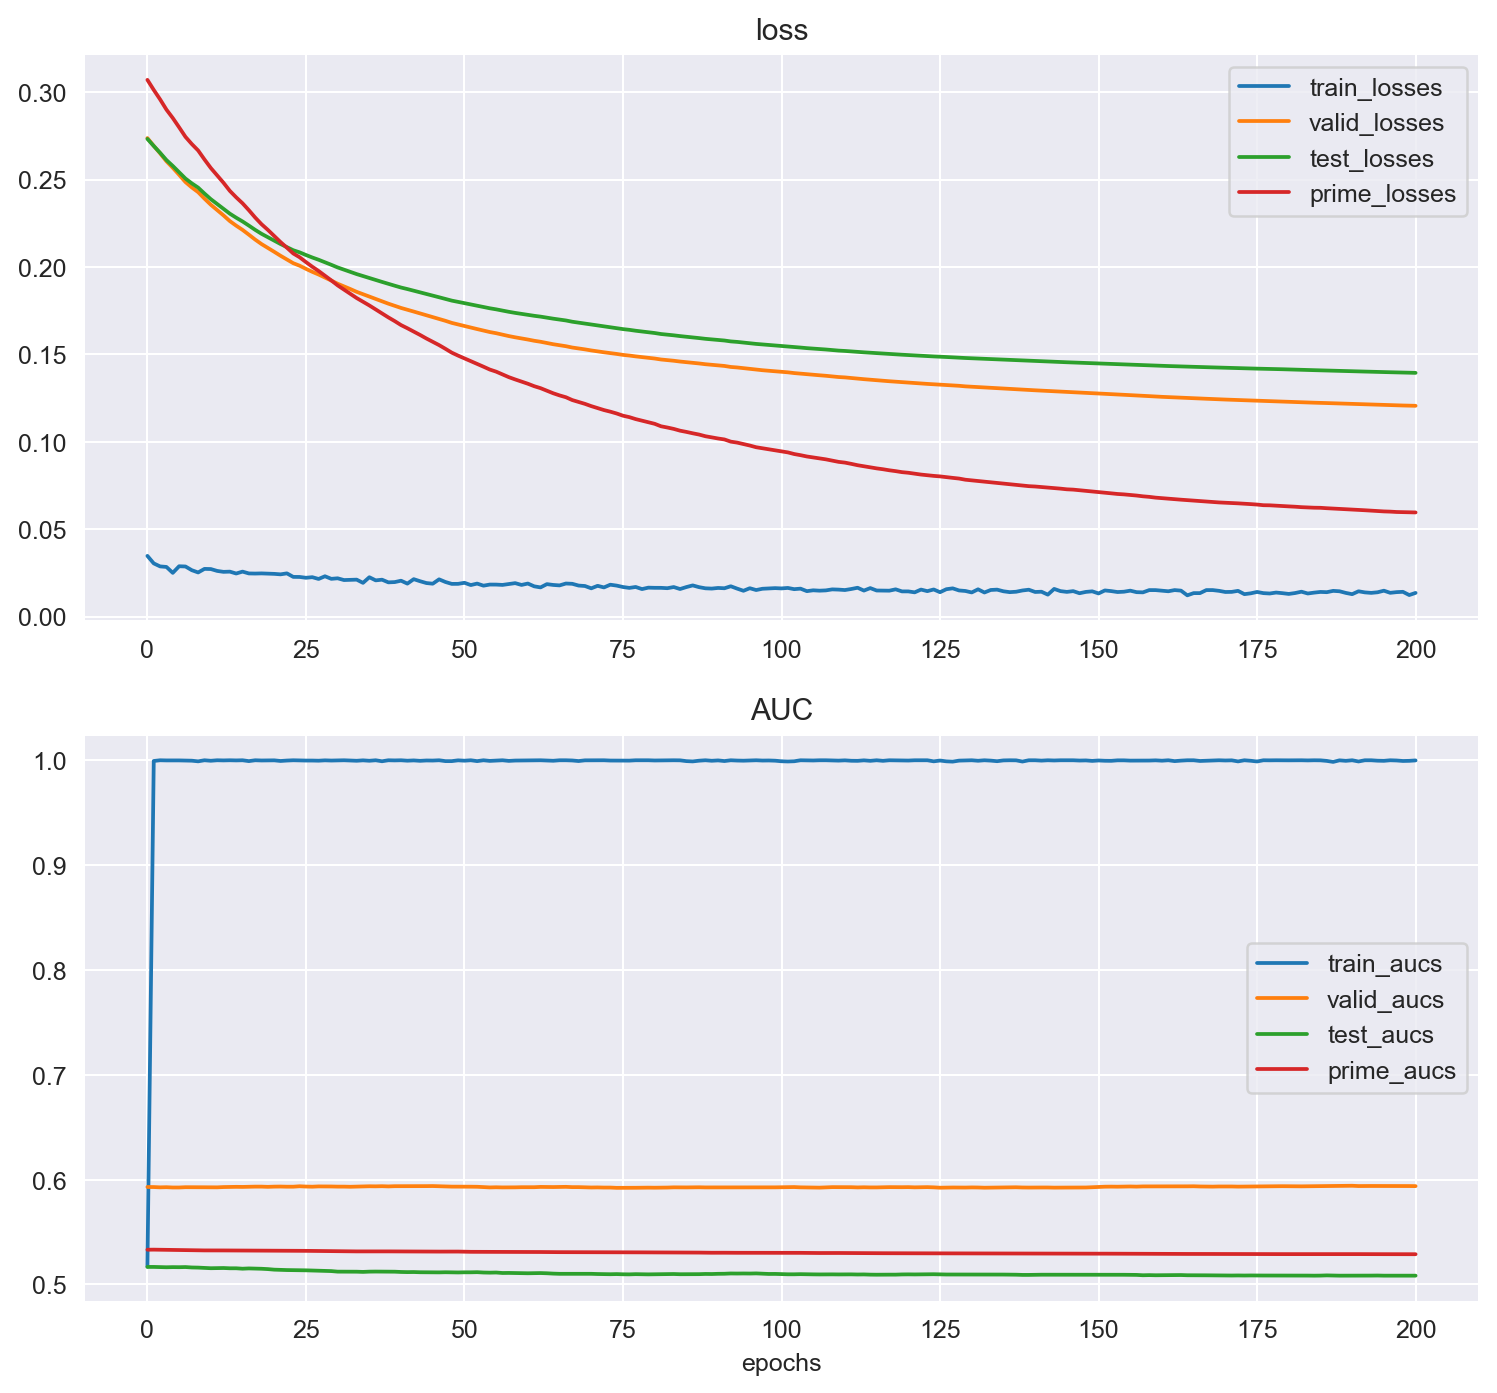

In [77]:
f,a = plt.subplots(2,1, figsize=(10,9))
a = a.ravel()
a[0].plot(train_losses, label='train_losses')
a[0].plot(valid_losses, label='valid_losses')
a[0].plot(test_losses, label='test_losses')
a[0].plot(prime_losses, label='prime_losses')
a[0].legend()
a[0].set_title('loss')
a[1].plot(train_aucs, label='train_aucs')
a[1].plot(valid_aucs, label='valid_aucs')
a[1].plot(test_aucs, label='test_aucs')
a[1].plot(prime_aucs, label='prime_aucs')
a[1].legend()
a[1].set_title('AUC')
a[1].set_xlabel('epochs')